<h2 style="color:red;">VI. Expérimentations numériques et résultats</h2>

Les performances du modèle sont évaluées à l’aide des indicateurs suivants :
<ul>
  <li>Courbe de perte (<i>loss</i> et <i>validation loss</i>)</li>
  <li>Courbe de précision (<i>accuracy</i>)</li>
  <li>Matrice de confusion normalisée</li>
  <li>Analyse des performances globales du modèle</li>
</ul>

<h2 style="color:red;">VII. Modélisation du problème </h2>
<h3 style="color: green;">1. pseudo-code 2</h3>

<h3>Initialisation</h3>
<ul>
  <li>Importation des bibliothèques nécessaires.</li>
  <li>Définition des paramètres globaux.</li>
</ul>

<h3>Chargement des données</h3>
<ul>
  <li>Lecture du fichier Excel contenant les données simulées.</li>
  <li>Vérification de l’existence du fichier.</li>
  <li>Arrêt du programme en cas d’erreur de chargement.</li>
</ul>

<h3>Séparation des données</h3>
<ul>
  <li><strong>X</strong> : ensemble des variables d’entrée.</li>
  <li><strong>y</strong> : variable cible correspondant aux classes.</li>
</ul>

<h3>Normalisation des données</h3>
<ul>
  <li>Application du <code>StandardScaler</code>.</li>
</ul>

<h3>Création des séquences temporelles</h3>
<ul>
  <li>Découpage des données en fenêtres temporelles successives.</li>
  <li>Chaque séquence contient un nombre fixe d’échantillons.</li>
  <li>L’étiquette correspond à la dernière valeur de la séquence.</li>
</ul>

<h3>Encodage des classes</h3>
<ul>
  <li>Transformation des classes en vecteurs <i>one-hot</i>.</li>
  <li>Format adapté à l’apprentissage du réseau de neurones.</li>
</ul>

<h3>Séparation apprentissage / test</h3>
<ul>
  <li>80&nbsp;% des données pour l’entraînement.</li>
  <li>20&nbsp;% pour l’évaluation du modèle.</li>
</ul>

<h3>Construction du modèle LSTM</h3>
<ul>
  <li>Réseau composé de plusieurs couches LSTM.</li>
  <li>Apprentissage des dépendances temporelles.</li>
  <li>Couche de sortie avec activation <em>softmax</em>.</li>
</ul>

<h3>Entraînement du modèle</h3>
<ul>
  <li>Optimisation avec l’algorithme Adam.</li>
  <li>Utilisation de l’arrêt anticipé (<em>Early Stopping</em>).</li>
</ul>

<h3>Évaluation des performances</h3>
<ul>
  <li>Analyse des courbes de perte et de précision.</li>
  <li>Calcul de la matrice de confusion.</li>
</ul>

<h3>Résultats finaux</h3>
<ul>
  <li>Prédiction des classes sur les données de test.</li>
  <li>Évaluation globale des performances du modèle.</li>
</ul>
 

<h2 style="color: red;">VIII. Code</h2>
<h3 style="color: green;">
 1. Importation des bibliothèques nécessaires</h3>



In [121]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns # Nécessaire pour la Matrice de Confusion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix



<h3 style="color: green;">
 2. configuration et chagement des données</h3>

In [109]:
###### # Chemins d'accès définis par le Code 1
DATA_DIR = 'data_lstm' # dossier où se trouve le fichier
NEW_EXCEL_OUTPUT_FILE = 'donnees_lstm_panne.xlsx' # nom du fichier Excel
EXCEL_OUTPUT_PATH = os.path.join(DATA_DIR, NEW_EXCEL_OUTPUT_FILE) #crée le chemin complet

TARGET_COLUMN = 'fault_class'   # C’est la colonne à prédire

#Paramètres du modèle
SEQUENCE_LENGTH = 50 # N = 50  # Chaque entrée du modèle contient 50 étapes consécutives
NUM_CLASSES = 8      # C0 à C7

try:
    df = pd.read_excel(EXCEL_OUTPUT_PATH, sheet_name='SimulationData')  #df est un DataFrame Pandas, c’est-à-dire un tableau, comme un tableau Excel.
except FileNotFoundError:
    print(f"Erreur : Le fichier {EXCEL_OUTPUT_PATH} est introuvable.")
    exit()

X_df = df.drop(columns=[TARGET_COLUMN]) #toutes les colonnes d’entrée (features) (Elle enlève la colonne fault_class du tableau.)
y_df = df[TARGET_COLUMN] #la colonne cible (fault_class)(les classes à prédire) (Elle récupère seulement la colonne fault_class)



<h3 style="color: green;">
 3. Prétraitement :Normalisation et séquençage</h3>

In [110]:

scaler = StandardScaler()  # Crée un objet StandardScaler pour normaliser les données (moyenne=0, écart-type=1)
X_scaled = scaler.fit_transform(X_df)  # Normalise les données X_df et renvoie un tableau NumPy



<ul>
  Cette fonction sert à transformer des données brutes ligne par ligne en séquences temporelles utilisables par un modèle LSTM
</ul>

In [111]:
# data : les données d’entrée 
#labels : la classe associée à chaque ligne
#seq_length : combien de lignes on regroupe pour former une séquence

def create_sequences(data, labels, seq_length):
    X_sequences = []  # On crée une liste vide pour stocker les séquences d’entrée
    y_sequences = []  # On crée une liste vide pour stocker les classes associées à chaque séquence
    
# len(data) - seq_length + 1 = Nombre de séquences possibles 
    for i in range(len(data) - seq_length + 1):  # Boucle pour créer des séquences 
        seq = data[i:i + seq_length]  # Extrait une séquence de longueur seq_length
        X_sequences.append(seq)  # Ajoute la séquence à la liste des features
        label = labels[i + seq_length - 1]  # Attribue le label de la fin de la séquence
        y_sequences.append(label)  # Ajoute le label correspondant à la liste
    
    return np.array(X_sequences), np.array(y_sequences)  # Convertit les listes en tableaux NumPy

<ul style="color: #2E86C1; font-weight: bold;">
 3.1. Création des séquences </ul>

In [112]:

X_seq, y_seq = create_sequences(X_scaled, y_df.values, SEQUENCE_LENGTH)  # Crée les séquences et les labels correspondants

y_one_hot = to_categorical(y_seq, num_classes=NUM_CLASSES)  # Convertit les labels en encodage one-hot pour Keras parce que 
#Le modèle ne peut pas apprendre directement avec des nombres comme 0, 1, 2, 3 Il a besoin de vecteurs (format utilisable par le réseau de neurones)

# X_train : données pour entraîner le modèle
# X_test : données pour tester le modèle
# y_train : classes pour l’entraînement
# y_test : classes pour le test

X_train, X_test, y_train, y_test = train_test_split( X_seq, y_one_hot, test_size=0.2, random_state=42, stratify=y_one_hot) 
#  train_test_split : sert à couper tes données en deux parties

# random_state=42 : Pour que le découpage soit toujours le même à chaque exécution.Sinon, à chaque lancement,
#les données seraient mélangées différemment.

# Sépare les données en train (80%) et test (20%) avec stratification pour conserver la proportion de classes




<h3 style="color: green;">4. Définition et entraînement du modèle LSTM</h3>

<p>
Ce code permet d’entraîner un modèle de deep learning de type <strong>LSTM</strong> afin
d’apprendre à reconnaître les différents types de pannes à partir des données temporelles.
</p>

<p>
Les données d’entrée <strong>X_train</strong> sont organisées sous la forme d’un tenseur à trois dimensions :
</p>

<ul>
  <li><strong>Nombre de séquences</strong> : nombre total d’exemples utilisés pour l’apprentissage</li>
  <li><strong>Longueur de la séquence</strong> : nombre d’instants temporels par séquence</li>
  <li><strong>Nombre de variables</strong> : nombre de capteurs ou de caractéristiques utilisées</li>
</ul>


In [113]:

#X_train.shape[0] : nombre total de séquences (on ne l’utilise PAS dans input_shape)
#X_train.shape[1] : nombre de pas de temps
#X_train.shape[2] : nombre de variables / capteurs

input_shape = (X_train.shape[1], X_train.shape[2]) 

model = Sequential()  # On crée un modèle séquentiel (c’est-à-dire : Les couches sont placées les unes après les autres, dans un ordre)
# Correction d'avertissement : utilise 'shape' au lieu de 'input_shape'
model.add(Input(shape=input_shape))  # Elle indique à quoi ressemblent les données qui entrent dans le modèle
#Le réseau a 50 neurones LSTM : Ces neurones analysent la dynamique temporelle des données
model.add(LSTM(50, return_sequences=True, name='LSTM_1')) 
model.add(LSTM(50, return_sequences=True, name='LSTM_2'))
# return_sequences=True : on veut envoyer toute la séquence à la couche suivante

model.add(LSTM(50, return_sequences=False, name='LSTM_3')) 
#return_sequences=False (par défaut) : elle résume toute la séquence en un seul vecteur pas seulement le dernier instant
#Dense() : Donne la prédiction finale
model.add(Dense(NUM_CLASSES, activation='softmax', name='Dense_Output'))
#softmax=softmax : Elle transforme les valeurs en probabilités

model.compile(optimizer='adam'#(C’est la méthode qui ajuste les poids du réseau pour réduire les erreurs)
              ,loss='categorical_crossentropy'#(La loss (fonction de perte) mesure à quel point le modèle se trompe)
         , metrics=['accuracy']#(le taux de bonnes prédictions)
                         )

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #À arrêter l’entraînement automatiquement quand le modèle n’apprend plus.

#Entraînement du modèle
history = model.fit(
    X_train, y_train,
    epochs=100, #Le modèle peut voir les données jusqu’à 100 fois. Mais grâce à EarlyStopping, il s’arrête plus tôt si nécessaire.
    batch_size=32, #Les données sont traitées par paquets de 32 échantillons à la fois.
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],# Active l’arrêt automatique quand le modèle n’améliore plus ses résultats.
    verbose=0 # Tu ne vois rien jusqu’à la fin
)
#Le modèle apprend en répétant plusieurs fois les données, et on regarde si ses erreurs diminuent ; s’il n’apprend plus, on arrête.



<h3 style="color: green;">5. Évaluation et génération des figures</h3>
<ul style="color: #2E86C1; font-weight: bold;">
 5.1.  Le modèle prédit des probabilités, on garde la plus grande pour avoir la classe finale, puis on compare avec la vraie classe pour évaluer la performance </ul>

In [114]:

y_pred_probs = model.predict(X_test, verbose=0) # Elle demande au modèle entraîné de faire des prédictions sur les données de test
# y_pred = contient la classe prédite
y_pred = np.argmax(y_pred_probs, axis=1) # donne-moi l’indice de la plus grande valeur
# y_true= vraies classes
y_true = np.argmax(y_test, axis=1)  #np.argmax(...) transforme ce vecteur en nombre :

# Génération des noms de classe C0, C1, ...
class_names = []
for i in range(NUM_CLASSES):
    class_names.append("C" + str(i))




 <ul style="color: #2E86C1; font-weight: bold;">
  5.2.   Évolution de la fonction d'erreur (Error/Loss) 
</ul>

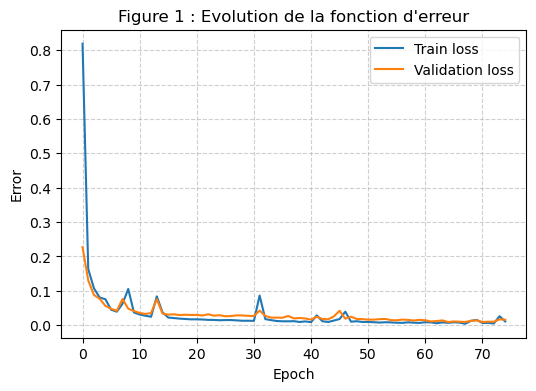

In [115]:

plt.figure(figsize=(6, 4))
# history.history['loss'] : contient les valeurs de la loss à chaque époque
plt.plot(history.history['loss'], label='Train loss', color='C0')
#history.history['val_loss'] : erreur du modèle sur les données de test
plt.plot(history.history['val_loss'], label='Validation loss', color='C1')
plt.title('Figure 1 : Evolution de la fonction d\'erreur')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# courbe bleu atteint presque zéro. Le modèle a mémorisé presque parfaitement les données d'entraînement
#Le modèle devient de plus en plus performant pour classer les séquences qui lui sont nouvelles (qu'il n'a jamais vues).



<h3>Interprétation:</h3>

<p>
La figure montre l’évolution de la fonction de perte (<em>loss</em>) du modèle au cours des différentes époques
d’entraînement. On observe une diminution rapide de la perte dès les premières itérations, ce qui indique que
le modèle apprend efficacement les relations présentes dans les données.
</p>

<p>
La courbe de validation suit de très près la courbe d’entraînement, ce qui montre que le modèle généralise
correctement et ne souffre pas de surapprentissage. La stabilisation des deux courbes à une valeur faible
confirme que le modèle a atteint une convergence satisfaisante.
</p>


<ul style="color: #2E86C1; font-weight: bold;">
 5.3. Évolution de la précision moyenne (Accuracy)
</ul>


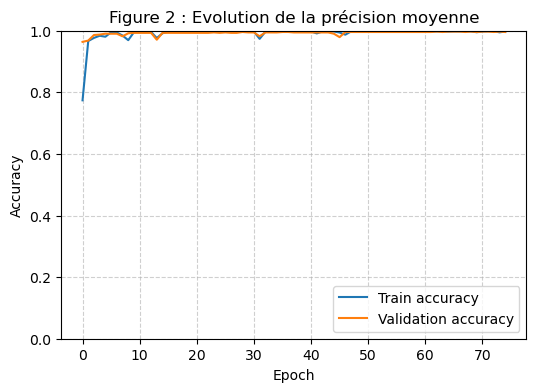

In [116]:

plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train accuracy', color='C0')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='C1')
plt.title('Figure 2 : Evolution de la précision moyenne')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1) # La précision est entre 0 et 1
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()




<h3>Interprétation:</h3>

<p>
La courbe montre que la précision du modèle augmente rapidement dès les premières époques,
atteignant presque 100&nbsp;%. Cette évolution indique que le modèle apprend efficacement
les caractéristiques des données.
</p>

<p>
Les courbes d’entraînement et de validation restent très proches l’une de l’autre, ce qui
montre une bonne capacité de généralisation. Cela signifie que le modèle ne surapprend pas
et qu’il est capable de prédire correctement les classes sur de nouvelles données.
</p>


 <ul style="color: #2E86C1; font-weight: bold;">
  5.4.  Matrice de Confusion
</ul>

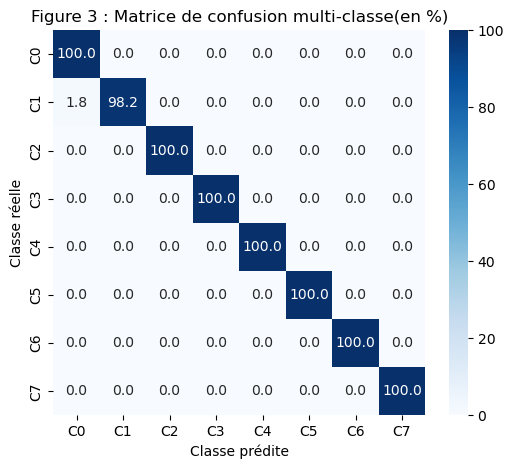

In [117]:

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Normalisation en pourcentage
cm = cm / cm.sum(axis=1, keepdims=True) * 100 # Cette ligne sert à transformer les nombres en pourcentages

# Affichage
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Figure 3 : Matrice de confusion multi-classe(en %)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

<h3>Interprétation</h3>

<p>
La matrice de confusion montre que le modèle reconnaît correctement la majorité des classes.
La concentration des valeurs sur la diagonale principale indique que les prédictions sont
globalement exactes.
</p>

<p>
Les erreurs de classification sont très limitées et concernent uniquement quelques confusions
mineures entre certaines classes proches. Cela démontre que le modèle est capable de distinguer
efficacement les différents types de pannes.
</p>



 <ul style="color: #2E86C1; font-weight: bold;">
  5.5.   Performance globale
</ul>

In [118]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy :", round(accuracy, 3))
print()
# 2. Précision et rappel par classe
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

for i in range(len(precision)):
    print(f"Classe {i}:")
    print(f"  Précision : {precision[i]:.3f}")
    print(f"  Rappel    : {recall[i]:.3f}")

Accuracy : 0.997

Classe 0:
  Précision : 0.978
  Rappel    : 1.000
Classe 1:
  Précision : 1.000
  Rappel    : 0.982
Classe 2:
  Précision : 1.000
  Rappel    : 1.000
Classe 3:
  Précision : 1.000
  Rappel    : 1.000
Classe 4:
  Précision : 1.000
  Rappel    : 1.000
Classe 5:
  Précision : 1.000
  Rappel    : 1.000
Classe 6:
  Précision : 1.000
  Rappel    : 1.000
Classe 7:
  Précision : 1.000
  Rappel    : 1.000



<h3>Interprétation :</h3>

<p>
Le modèle présente de très bonnes performances globales. Il est correctement entraîné et
démontre une excellente capacité de généralisation sur des données jamais vues auparavant.
Cela indique que l’apprentissage a été efficace et que le modèle est fiable pour la
détection et la classification des différents types de pannes.
</p>

<h2 style="color:red;">IX. Analyse des résultats</h2>

<h3>Avantages</h3>
<ul>
  <li>Le modèle LSTM capture efficacement les dépendances temporelles présentes dans les données.</li>
  <li>Il présente de bonnes performances sur l’ensemble des classes.</li>
  <li>L’approche est adaptée à la détection automatique de pannes à partir de signaux temporels.</li>
</ul>

<h3>Limites</h3>
<ul>
  <li>Les données utilisées sont simulées et ne proviennent pas d’un système réel.</li>
  <li>Certaines classes de pannes peuvent être similaires, entraînant des confusions possibles.</li>
  <li>Les performances dépendent fortement du choix des hyperparamètres (taille de séquence, nombre de neurones, etc.).</li>
</ul>

<h3>Reproductibilité</h3>
<ul>
  <li>Le travail présenté est globalement reproductible, car la méthodologie est bien décrite et les différentes étapes du traitement des données sont clairement expliquées. Les algorithmes utilisés, ainsi que la structure générale du modèle, permettent à un autre chercheur de refaire les mêmes expériences.</li>
</ul>
<h2 style="color:red;">X. Conclusion</h2>
<p>
Ce travail a démontré qu’un modèle basé sur les réseaux de neurones récurrents de type LSTM
permet de détecter efficacement différents types de pannes à partir de données temporelles.
</p>

<p>
Les résultats obtenus montrent une bonne capacité de généralisation du modèle. 
Des améliorations futures pourraient inclure :
</p>

<ul>
  <li>l’utilisation de données réelles issues de systèmes industriels,</li>
  <li>l’enrichissement des scénarios de pannes simulées,</li>
  <li>l’optimisation de l’architecture du réseau et des hyperparamètres.</li>
</ul>

<h2 style="color:red;">XI. Références</h2>

<ul>
  <li>Documentation officielle TensorFlow / Keras.</li>
  <li>Saddem et al. (2022). Méthodes de détection de pannes basées sur l’apprentissage profond.</li>
</ul>
